In [ ]:
import numpy as np
import tensorflow as tf
import os
import sys

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.models import load_model # type: ignore
from tensorflow import keras
from tensorflow.keras import backend as K # type: ignore

from glob import glob
from PIL import Image


In [19]:
size = (2048, 2048)

input_shape = [512, 512, 3]

In [20]:
def read_and_process_image(image_path):
    # Wczytaj obraz kolorowy (BGR)
    img = cv2.imread(f'all/images/{image_path}.jpg')

    img = img.astype(np.float32)  # konwertujemy typ danych na float32
    img = img / 255.0
    img = cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)
       
    return img


def read_mask(image_name):
    # Wczytanie maski eksperckiej
    mask = cv2.imread(f'all/manual1/{image_name}.tif', cv2.IMREAD_GRAYSCALE)

    mask = mask.astype(np.float32)  # konwertujemy typ danych na float32
    mask = mask / 255.0
    mask = cv2.resize(mask, size)

    return mask

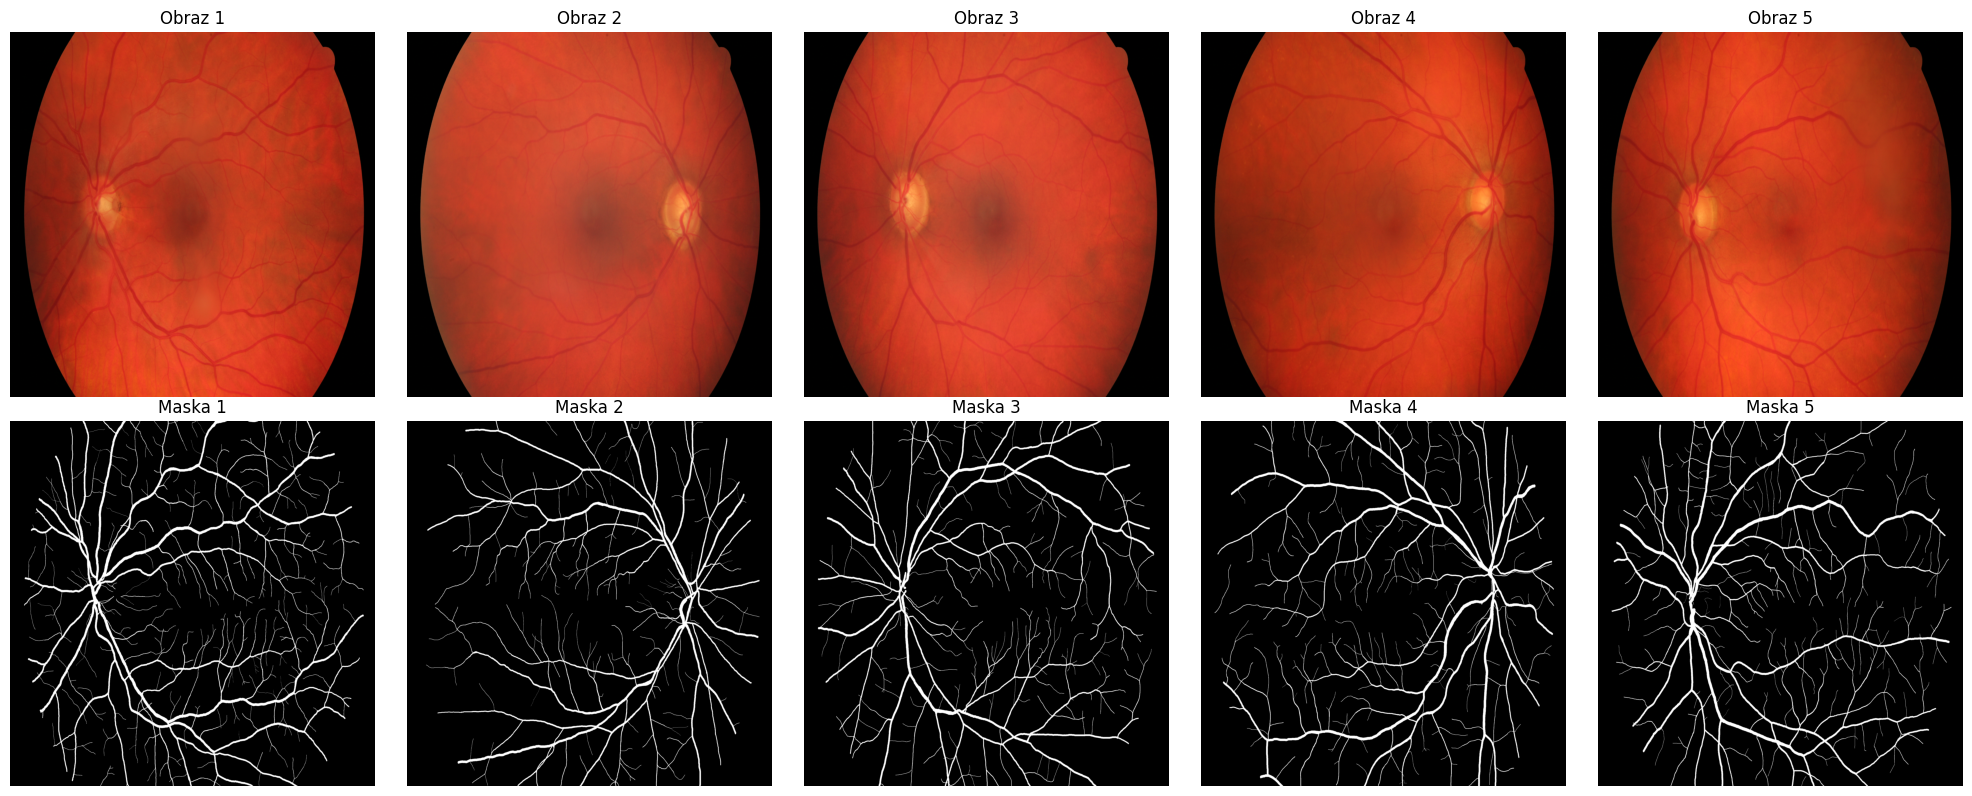

In [21]:
# Przykład użycia dla wielu obrazów
image_names = ['02_g', '03_g', '04_g', '05_g', '06_g']

processed_images = []
masks = []

for name in image_names:
    processed_img = read_and_process_image(name)
    #size = processed_img.size 
    mask = read_mask(name)
    processed_images.append(processed_img)
    masks.append(mask)
    

processed_images = np.array(processed_images)  # (N, H, W, 3)
masks = np.array(masks)                        # (N, H, W) lub (N, H, W, 1) w zależności od funkcji read_mask


plt.figure(figsize=(20, 8))

for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(cv2.cvtColor(processed_images[i], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Obraz {i+1}')

for i in range(5):
    plt.subplot(2, 5, i+6)
    plt.imshow(masks[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Maska {i+1}')

plt.tight_layout()
plt.show()

In [22]:
def extract_patches(image, mask, patch_size=(101, 101), num_patches=10, vessel_focus=True, threshold=0.01):
    img_patches = []
    mask_patches = []

    h, w = image.shape[:2]
    ph, pw = patch_size

    for _ in range(num_patches):
        x = np.random.randint(0, w - pw)
        y = np.random.randint(0, h - ph)

        patch_img = image[y:y+ph, x:x+pw]
        patch_mask = mask[y:y+ph, x:x+pw]

        if vessel_focus:
            if np.sum(patch_mask) > threshold * (ph * pw):  # np.sum > % naczyń
                img_patches.append(patch_img)
                mask_patches.append(patch_mask)
        else:
            img_patches.append(patch_img)
            mask_patches.append(patch_mask)

    return img_patches, mask_patches

# ---------- Użycie ----------

processed_images = []
masks = []

for name in image_names:
    full_img = read_and_process_image(name)
    full_mask = read_mask(name)

    # Pozytywne patche: z naczyniami
    pos_imgs, pos_masks = extract_patches(full_img, full_mask, vessel_focus=True, num_patches=5)

    # Negatywne patche: tło
    neg_imgs, neg_masks = extract_patches(full_img, full_mask, vessel_focus=False, num_patches=5)

    processed_images.extend(pos_imgs + neg_imgs)
    masks.extend(pos_masks + neg_masks)

processed_images = np.array(processed_images)
masks = np.array(masks)


In [23]:
# Podział na zbiory treningowe i walidacyjne
X_train, X_valid, Y_train, Y_valid = train_test_split(processed_images, masks, test_size=0.33, random_state=42)

#wczytanie modelu

#czesto uzywany jako enkoder w unet
base_model = tf.keras.applications.MobileNetV2(input_shape, include_top=False)  #include_top=False -> Pomija ostatnią (klasyfikacyjną) warstwę modelu

# Pobieramy warstwy z różnych głębokości (do skip connections)
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Stwórz model enkodera
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

# Stwórz dekoder U-Net
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]


def unet_model(output_channels):
    # Enkoder
    inputs = tf.keras.layers.Input(shape=input_shape)
    skips = down_stack(inputs)
    x = skips[-1]  # głębokie cechy (najmniejszy rozmiar)

    skips = reversed(skips[:-1])

    # Dekoder + skip-connections
    #up - dekoder
    #skip - enkoder
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    # Ostatnia warstwa wyjściowa — 1 kanał (lub output_channels)
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same', activation='sigmoid'  # sigmoid do binarnej maski, softmax dla wielu klas
    )

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


/var/folders/5x/6grr61gd1fv_14f2c7m11pqh0000gn/T/ipykernel_28921/2348369028.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape, include_top=False)  #include_top=False -> Pomija ostatnią (klasyfikacyjną) warstwę modelu


In [24]:
# Dice coefficient jako metryka
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)  # spłaszczenie
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [25]:
def tversky_loss2(y_true, y_pred, alpha=0.7, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    
    TP = tf.keras.backend.sum(y_true_f * y_pred_f)
    FP = tf.keras.backend.sum((1 - y_true_f) * y_pred_f)
    FN = tf.keras.backend.sum(y_true_f * (1 - y_pred_f))
    
    return 1 - (TP + smooth) / (TP + alpha * FN + (1 - alpha) * FP + smooth)


In [26]:
import tensorflow as tf
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    
    cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
    weight = alpha * y_true * K.pow(1 - y_pred, gamma) + \
             (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
    loss = weight * cross_entropy
    return K.mean(loss)

def tversky_loss(y_true, y_pred, alpha=0.85, smooth=1e-6):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    TP = K.sum(y_true * y_pred)
    FP = K.sum((1 - y_true) * y_pred)
    FN = K.sum(y_true * (1 - y_pred))

    tversky_index = (TP + smooth) / (TP + alpha * FN + (1 - alpha) * FP + smooth)
    return 1 - tversky_index

def combo_loss(y_true, y_pred):
    fl = focal_loss(y_true, y_pred)
    tl = tversky_loss(y_true, y_pred)
    return 0.5 * fl + 0.5 * tl


In [27]:


OUTPUT_CLASSES = 1  #segmentacja 1 klasy
model = unet_model(output_channels=OUTPUT_CLASSES)

model.compile(
    optimizer='adam',
    loss=combo_loss, 
    metrics=[dice_coef]
)

#uczenie modelu 
model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=20)


Epoch 1/20


ValueError: Input 0 of layer "functional_12" is incompatible with the layer: expected shape=(None, 512, 512, 3), found shape=(32, 101, 101, 3)

In [ ]:
predictions = model.predict(X_train)

threshold = 0.55
pred_masks = (predictions > threshold).astype(np.uint8)
y_true = Y_train.reshape(-1)
y_pred = pred_masks.reshape(-1)
y_true = y_true.astype(np.uint8)
y_pred = y_pred.astype(np.uint8)

# y_true i y_pred muszą być binarne (0/1)
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)
# Sensitivity (Recall, True Positive Rate)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
# Specificity (True Negative Rate)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
# Mean arithmetic (średnia arytmetyczna sensitivity i specificity)
mean_arithmetic = (sensitivity + specificity) / 2
# Mean geometric (średnia geometryczna sensitivity i specificity)
mean_geometric = np.sqrt(sensitivity * specificity)

print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Mean Arithmetic:", mean_arithmetic)
print("Mean Geometric:", mean_geometric)

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 570ms/step
Accuracy: 0.9576948917273319
Sensitivity: 0.7683241524640467
Specificity: 0.9703272792379366
Mean Arithmetic: 0.8693257158509917
Mean Geometric: 0.8634384080136996


In [ ]:
# Przykład użycia dla wielu obrazów
image_names = ['07_g', '08_g', '09_g', '10_g', '11_g']

processed_images = []
masks = []

for name in image_names:
    processed_img = read_and_process_image(name)
    mask = read_mask(name)
    processed_images.append(processed_img)
    masks.append(mask)
    

processed_images = np.array(processed_images)  # (N, H, W, 3)
masks = np.array(masks)  

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


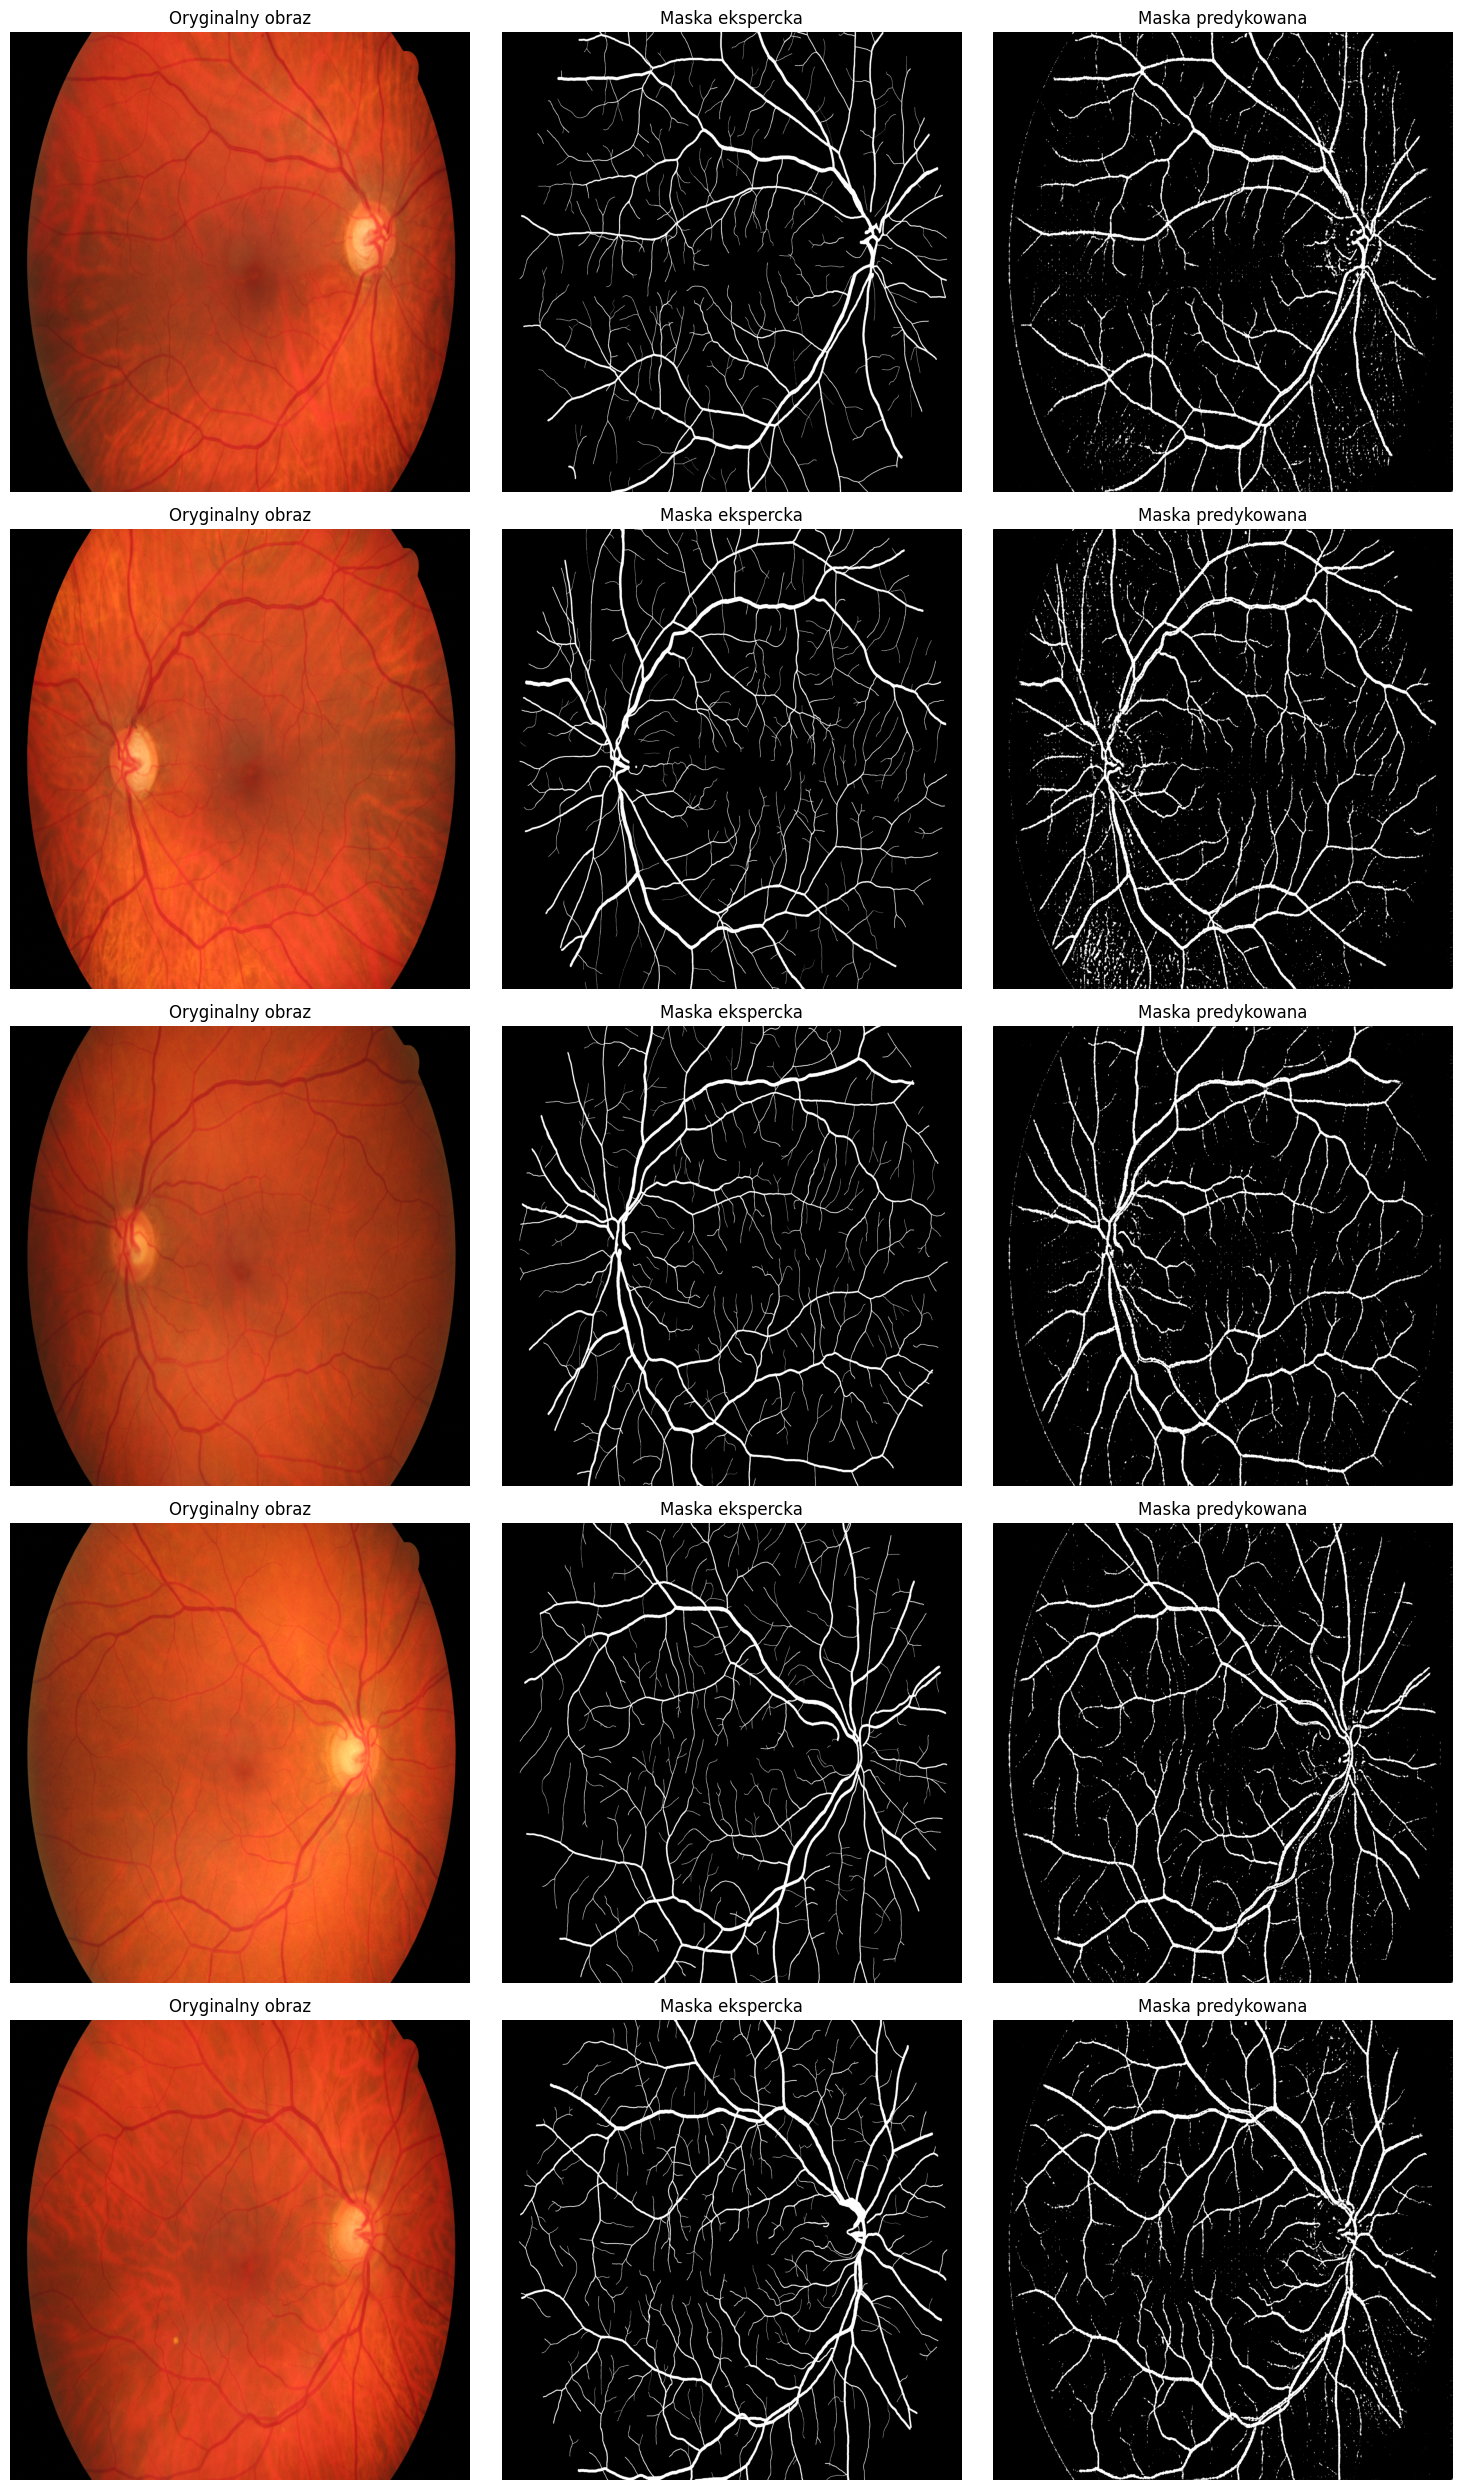

In [ ]:
predictions = model.predict(processed_images)
pred_masks = (predictions > threshold).astype(np.uint8)

num_images = len(processed_images)

plt.figure(figsize=(15, num_images * 5))

for i in range(num_images):
    # Oryginalny obraz
    plt.subplot(num_images, 3, i * 3 + 1)
    plt.imshow(cv2.cvtColor(processed_images[i], cv2.COLOR_BGR2RGB))
    plt.title("Oryginalny obraz")
    plt.axis('off')
    
    # Maska ekspercka (prawdziwa)
    plt.subplot(num_images, 3, i * 3 + 2)
    plt.imshow(masks[i], cmap='gray')
    plt.title("Maska ekspercka")
    plt.axis('off')
    
    # Maska predykowana
    plt.subplot(num_images, 3, i * 3 + 3)
    plt.imshow(pred_masks[i].squeeze(), cmap='gray')
    plt.title("Maska predykowana")
    plt.axis('off')

plt.tight_layout()
plt.show()